In [346]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame, Series
from sklearn.neighbors import KNeighborsClassifier
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from sklearn.svm import SVC

# BROAD PREPROCESSING

I want to manually encode binary columns, assigning the Y and N (or equivalent) values to 1 and 0, respectively. For string columns such as "EDUCATION", however, I will use one hot encoding to minimize potential errors.

Null values will also need to be handled effectively. I will replace all null values in binary or ordinal columns with the column's mode, since that means that there is essentially a 50% chance to get the entry "right," but I will use the column's median for numerical columns.

In [347]:
# Read in the Credit Card dataset
credit_base = pd.read_csv("../Week 07/Credit_card.csv")
labels = pd.read_csv("../Week 07/Credit_card_label.csv")

# Merge Credit_card.csv and Credit_card_label.csv so that there's an additional column representing whether the entry was accepted or denied
# for a credit card
credit_df = pd.merge(credit_base, labels, on = 'Ind_ID')

credit_df.head(10)

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
5,5009753,NaN,Y,N,0,315000.0,Pensioner,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
6,5009754,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
7,5009894,F,N,N,0,180000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22134.0,365243,1,0,0,0,NaN,2,1
8,5010864,M,Y,Y,1,450000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18173.0,-678,1,0,1,1,Core staff,3,1
9,5010868,M,Y,Y,1,450000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-18173.0,-678,1,0,1,1,Core staff,3,1


In [348]:
# Define the function that standardizes the given column, with type hinting and a default argument when appropriate
def std_gender(col: Series = credit_df['GENDER']) -> Series:
    m = {'M' : 1, 'F' : 2}
    col = col.map(m)
    col = col.fillna(col.mode().iloc[0]) # I'm replacing all null values with the mode since the responses in this column are binary; the
    # most commonly occurring value makes sense to substitute null with as we proverbially have a 50-50 shot of getting the answer right
    return col

credit_df['GENDER'] = std_gender()

# Define the function that standardizes the given column, with type hinting and a default argument when appropriate
def std_car(col: Series = credit_df['Car_Owner']) -> Series:
    m = {'Y' : 1, 'N' : 2}
    col = col.map(m)
    col = col.fillna(col.mode().iloc[0]) # I'm replacing all null values with the mode since the responses in this column are binary; the
    # most commonly occurring value makes sense to substitute null with as we proverbially have a 50-50 shot of getting the answer right
    return col

credit_df['Car_Owner'] = std_car()

# Define the function that standardizes the given column, with type hinting and a default argument when appropriate
def std_property(col: Series = credit_df['Propert_Owner']) -> Series:
    m = {'Y' : 1, 'N' : 2}
    col = col.map(m)
    col = col.fillna(col.mode().iloc[0]) # I'm replacing all null values with the mode since the responses in this column are binary; the
    # most commonly occurring value makes sense to substitute null with as we proverbially have a 50-50 shot of getting the answer right
    return col

credit_df['Propert_Owner'] = std_property()

# One hot encode all categorical string columns
def encode(col: Series, df: DataFrame = credit_df) -> DataFrame:
    temp = pd.get_dummies(df[col])
    df = df.drop(columns = [col])
    df = df.join(temp)
    return df


cols = ['Type_Income', 'EDUCATION', 'Marital_status', 'Housing_type', 'Type_Occupation']

for col in cols:
    credit_df = encode(col, credit_df)

# For miscellaneous null cleaning
def null_sub(df: DataFrame = credit_df) -> DataFrame:
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']: # Numerical columns
            median = df[col].median()
            df[col] = df[col].fillna(median)
        elif df[col].dtype == 'object': # Categorical columns
            mode = df[col].mode().iloc[0]
            df[col] = df[col].fillna(mode)
    return df

credit_df = null_sub()

credit_df.head(20)

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,...,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
0,5008827,1.0,1,1,0,180000.0,-18772.0,365243,1,0,...,False,False,False,False,False,False,False,False,False,False
1,5009744,2.0,1,2,0,315000.0,-13557.0,-586,1,1,...,False,False,False,False,False,False,False,False,False,False
2,5009746,2.0,1,2,0,315000.0,-15661.5,-586,1,1,...,False,False,False,False,False,False,False,False,False,False
3,5009749,2.0,1,2,0,166500.0,-13557.0,-586,1,1,...,False,False,False,False,False,False,False,False,False,False
4,5009752,2.0,1,2,0,315000.0,-13557.0,-586,1,1,...,False,False,False,False,False,False,False,False,False,False
5,5009753,2.0,1,2,0,315000.0,-13557.0,-586,1,1,...,False,False,False,False,False,False,False,False,False,False
6,5009754,2.0,1,2,0,315000.0,-13557.0,-586,1,1,...,False,False,False,False,False,False,False,False,False,False
7,5009894,2.0,2,2,0,180000.0,-22134.0,365243,1,0,...,False,False,False,False,False,False,False,False,False,False
8,5010864,1.0,1,1,1,450000.0,-18173.0,-678,1,0,...,False,False,False,False,False,False,False,False,False,False
9,5010868,1.0,1,1,1,450000.0,-18173.0,-678,1,0,...,False,False,False,False,False,False,False,False,False,False


# ADDITIONAL PREPROCESSING FOR ASSIGNMENT #9

At a high-level, here are the steps to preprocessing:
1. Cleaning up null values
2. Data cleaning (dashes, odd characters, etc)
3. Remove extreme outliers
4. One-Hot encoding
5. Convert Categorical values to numerical (sometimes that is the same as 3)
6. Standardization/Normalization
7. Deal with multicollinearity (can be caused by 3)

I have completed almost all of these steps; however, a viable step that remains is checking for and addressing multicollinearity, as I will standardize teh data after first applying some preliminary models, similar to the approach I took in assignment #7.


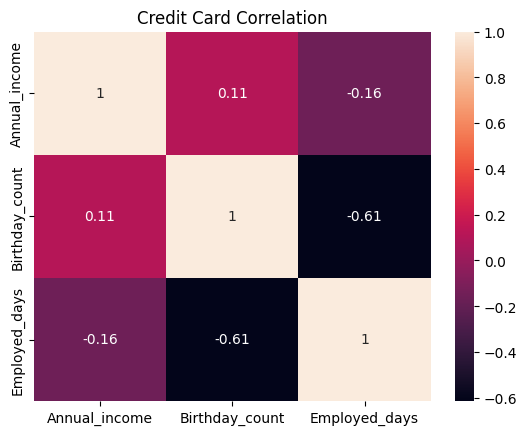

,Annual_income,Birthday_count,Employed_days
Annual_income,1.000000,0.110682,-0.158966
Birthday_count,0.110682,1.000000,-0.614271
Employed_days,-0.158966,-0.614271,1.000000


In [349]:
data = credit_df[['Annual_income', 'Birthday_count', 'Employed_days']]
corrMatrix = data.corr()

sns.heatmap(corrMatrix, annot=True)
plt.title('Credit Card Correlation')
plt.show()

corrMatrix

With the above, we can see that there isn't a particularly strong existence of multicollinearity among the numerical columns; with this in mind, we can safely move onto the next steps.

# COMBINED SAMPLING

I will utilize a combined sampling approach for this dataset as our endgoal is whether or not someone will be accepted for a credit card. To elaborate, there are exponentially fewer cases where label is 1 than the alternative; to this end, oversampling is not ideal as there is a large imbalance in our target variable, so we need all the data we can get to train our models for prediction.

In [350]:
# Show the imbalance in labels
credit_df['label'].value_counts()

label
0    1373
1     175
Name: count, dtype: int64

In [351]:
def smoteenn(X, y):
    
    smoteenn = SMOTEENN(random_state = 42)
    X_new, y_new = smoteenn.fit_resample(X, y)
    return X_new, y_new

# UNIVARIATE LINEAR REGRESSION

In [352]:
# X is what we are using to predict, while y is what we are predicting. Univariate linear regression only involves one independent variable,
# so I chose the 'Annual_income' column since it logically seems like the predominant factor deciding the label, other than residence.
X = credit_df[['Annual_income']]
y = credit_df['label']

# Conduct the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) # Set to 42 for congruence with our class 
# notes; I like 02 as well, though :)
X_train_new, y_train_new = smoteenn(X_train, y_train)

# Create and fit the linear regression model
lReg = LinearRegression()
lReg.fit(X_train_new, y_train_new)

# Predict on the test set
lPred = lReg.predict(X_test)

# Check accuracy; abhorrent
r2 = lReg.score(X_test, y_test)
print(r2)

-0.3301027912955401


### TAKEAWAYS

Before oversampling, our R-Squared score was about -0.016. Afterwards, its closer to -0.33. This decrease in performance seems to be indicative of the fact that annual_income alone is not enough to predict whether someone will receive a credit card, and a balanced sampling approach simply diluted the dataset. With so many different variables at play, it lines up that there are other considerations that need to be made when predicting 'label.' Regardless, perhaps the most damning reason for univariate linear regression's failure stems not from "univariate," but from "linear." We are trying to predict a binary outcome-- whether someone will be approved for a credit card or not, yes or no-- which linear regression is not suitable for, since it is liable to produce predictions outside our range of acceptable answers, which is [0,1].

# K-NEAREST NEIGHBOR (KNN)

In [353]:
# First, we need to establish our train-test split as well as our variables

X = credit_df.drop('label', axis = 1)
y = credit_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train_new, y_train_new = smoteenn(X_train, y_train)

# Find the optimal K value
def optimalNeighbors(X_train, X_test, y_train, y_test) -> int:
    maxScore = 0
    maxK = 1

    for currK in range(1, 100):
        knn = KNeighborsClassifier(n_neighbors = currK)
        knn.fit(X_train, y_train)
        knnPred = knn.predict(X_test)
        currScore = knn.score(X_test, y_test)
        if (currScore > maxScore):
            maxScore = currScore
            maxK = currK

    return maxK

# Establish K
k = optimalNeighbors(X_train_new, X_test, y_train_new, y_test)

# Train the KNN model using the optimal number of neighbors found above
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train_new, y_train_new)

# Predict
kPred = knn.predict(X_test)
print(knn.score(X_test, y_test))

0.7010752688172043


### TAKEAWAYS

The accuracy of the KNN model has deteriorated from 90.75 to 0.7, but the data is fairly imbalanced. Here's a better representation of how the model performed.

In [354]:
class_report = classification_report(y_test, kPred)
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.71      0.81       422
           1       0.18      0.60      0.27        43

    accuracy                           0.70       465
   macro avg       0.56      0.66      0.54       465
weighted avg       0.88      0.70      0.76       465



With the above, we can see that the model performed fairly inadequately. There was a decent recall score for label; however, both precision and f1-score were not up to par.

# LOGISTIC REGRESSION

In [355]:
X = credit_df.drop('label', axis = 1)
y = credit_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train_new, y_train_new = smoteenn(X_train, y_train)

regression = LogisticRegression(random_state = 42).fit(X_train_new, y_train_new)
y_predicted = regression.predict(X_test)

regression.score(X_test, y_test)

/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5774193548387097

### TAKEAWAYS

After applying a combined sampling approach, the accuracy score deteriorated from 90.3 to 0.58, considerably lower than KNN. Still, logistic regression is far superior to linear regression for this use case, which, of course, is to be expected, as logistic regression is far more suited to predicting binary or otherwise deterministic outcomes. Here are some more metrics.

In [356]:
class_report = classification_report(y_test, y_predicted)
print(class_report)

              precision    recall  f1-score   support

           0       0.91      0.59      0.72       280
           1       0.11      0.47      0.18        30

    accuracy                           0.58       310
   macro avg       0.51      0.53      0.45       310
weighted avg       0.83      0.58      0.66       310



Pretty bad performance, all around.

# NORMALIZATION

In [357]:
X = credit_df.drop('label', axis = 1)
y = credit_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train_new, y_train_new = smoteenn(X_train, y_train)
# Use StandardScaler() so that the mean is 0 and the standard deviation is 1, making the data more centralized
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train_new)
X_test = sc.fit_transform(X_test)

# Use univariate linear regression on the newly normalized data
lReg = LinearRegression()
lReg.fit(X_train_std, y_train_new)

# Predict on the test set
lPred = lReg.predict(X_test)

# Check accuracy
r2 = lReg.score(X_test, y_test)
print(r2)

-1.4103298927386823e+21


In [358]:
# Use KNN using the newly normalized data

knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train_std, y_train_new)

# Predict
kPred = knn.predict(X_test)
print(knn.score(X_test, y_test))

0.8741935483870967


In [359]:
# Use logistic regression using the newly normalized data

regression = LogisticRegression(random_state = 42).fit(X_train_std, y_train_new)
y_predicted = regression.predict(X_test)

regression.score(X_test, y_test)

0.24193548387096775

### TAKEAWAYS

Interestingly, it seems as though normalizing the data after ined sampling made univariate linear regression and KNN perform slightly worse (KNN dropped from ~90% to 87%), while logistic regression performed far worse (0.24 from 0.51).

# ROC CURVE

I am going to utilize the scikit-learn.org articles on the ROC curve and AUC to visualize my KNN model.

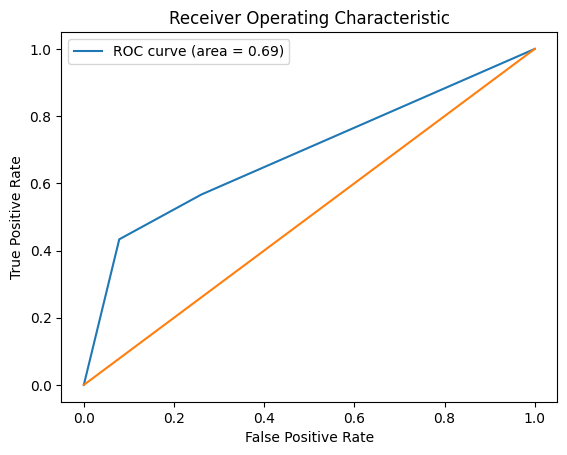

ROC AUC: 0.6872023809523811


In [360]:
def create_roc_curve(y_test, y_prob):
    
    fp, tp, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fp, tp)
    
    plt.figure()
    plt.plot(fp, tp, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='upper left')
    plt.show()
    
    return roc_auc

y_prob = knn.predict_proba(X_test)[:, 1]
roc_auc = create_roc_curve(y_test, y_prob)
print(f"ROC AUC: {roc_auc}")

### TAKEAWAYS

My area under the curve is closer to 0.69, which means that there's a pretty high margin for error in my model. Of course, my model is better at predicting the ends of the data, which is to be expected, with the highest capacity for error in the first quartile of data.

# LINEAR SVM

An SVM model can be useful when we're tryiing to find outliers; however, they are prone to overfitting and less-than-optimal when there's a strong imbalance in the target feature, but we'll see how it performs after application.

In [361]:
def svm(df, col):
    X = df.drop(col, axis=1)
    y = df[col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    classifier = SVC(kernel = 'linear', random_state = 42, class_weight = 'balanced') # Using class_weight here to offset the high imbalance
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(class_report)

svm(credit_df, 'label')

              precision    recall  f1-score   support

           0       0.92      0.25      0.39       422
           1       0.10      0.79      0.17        43

    accuracy                           0.30       465
   macro avg       0.51      0.52      0.28       465
weighted avg       0.84      0.30      0.37       465



### TAKEAWAYS
The SVM model did indeed perform the best after combined sampling; however, as predicted, there is a somewhat bad attempt to predict the label when it is positive due to the imbalance in the target variable, which the model counteracts by the high score when predicting negative cases. This is not an issue when the predictive variable is binary (if we are predicting one outcome at a high rate, then it follows that the ones not predicted must reliably be the other outcome); however, this can certainly pose an issue when the target is not binary or categorical.

# Final Thoughts on Outlier Detection

Outlier detection is very important in data science; by not effectively tackling outliers by standardizing data and utilizing strong statistical analysis, we are hindering the quality of our models and compromise data by inciting leakage and obfuscation. A few methods of detecting outliers utilized above include calculating area under the mean curve and visualization techniques, but some other strategies including using the Z-Score, which measures how far data tends to deviate from the mean, and the IQR, or Interquartile Range, which identifies outliers based on the basic spread of the data.